# Build an autonomous multi-agents workflow to write picture book
## Overall intro
You are running a virtual cartoon studio, the best and creative cartoon studio in the world. Several agents are hired in this studio including a cartoonist, screenwriter, editor, art designer, story illustrator, and translator. All the agents are powered by Amazon Bedrock. You will use a multi-agent workflow to create a illustrated book. You only need to provide a simple idea, and they can transform your idea into an engaging storybook with a twisting plot, featuring well-developed main characters, supporting characters, and antagonists whose personas will remain consistent throughout, accompanied by coherent illustrations and captions. You can create illustrated book from any idea you have

## Part 1
- **Goal**: Write a outline for a story
- In this step, we will create two agents "cartoonist" and "screenwriter", to create an outline.
- The cartoonist create an initial draft, and then ask screenwriter to create the characters. Then cartoonist will revise the outline draft by incooperating the characters.
- 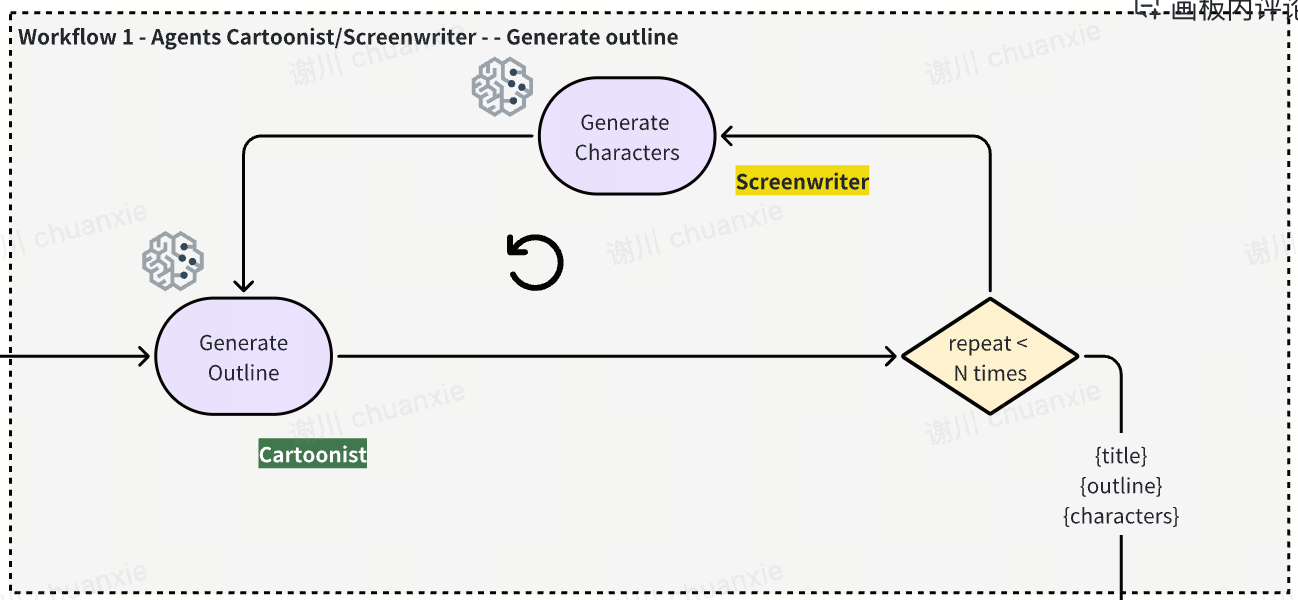

## 1. Install dependecies

In [96]:
%pip install -Uq langchain_community==0.2.10 langgraph==0.1.16 langchain-aws==0.1.12 python-docx docx2pdf

Note: you may need to restart the kernel to use updated packages.


## 2. Prerequisites code  
### 2.1 Import Utils functions

- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [23]:
from story_agents.llm_utils import CustJsonOuputParser,TextOuputParser,dict_to_obj

- we need to reconstruct the messages send to LLM strictly follow the turns ["user","assistant"]

In [5]:
from story_agents.llm_utils import convert_message_name,reconstruct_to_claude_messages,swap_roles

### 2.2 Initiailize LLM models

In [8]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
llm_sonnet = ChatBedrock(model_id=model_id,
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                )
llm = llm_sonnet

## 3 Agent Roles settings

- In this step, we will create two agents "cartoonist" and "screenwriter", to create an outline.
- The cartoonist create an initial draft, and then ask screenwriter to create the characters. Then cartoonist will revise the outline draft by incooperating the characters.

In [11]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [12]:
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio.
      """,
      
"screenwriter":  
      company_setting+"""You are a Screenwriter.
Your task is to create a main character and a diverse and distinct group of supporting characters for a new story, based on the provided topic and outline.
For each supporting character, please provide the following:
1. A unique name and role in the story (e.g. sidekick, mentor, rival, etc.)
2. A brief description of their perspective, affiliation, or background related to the story's themes
3. An explanation of what aspects of the story they will focus on or influence
Additionally, think step-by-step about how to make this group of characters distinct and complementary to create an engaging, multifaceted narrative
""",
}

## 4.Create Prompts template and Chains

### 4.1 Define structure output for Outline
- an Outline object consist of a list of chapter objects
- 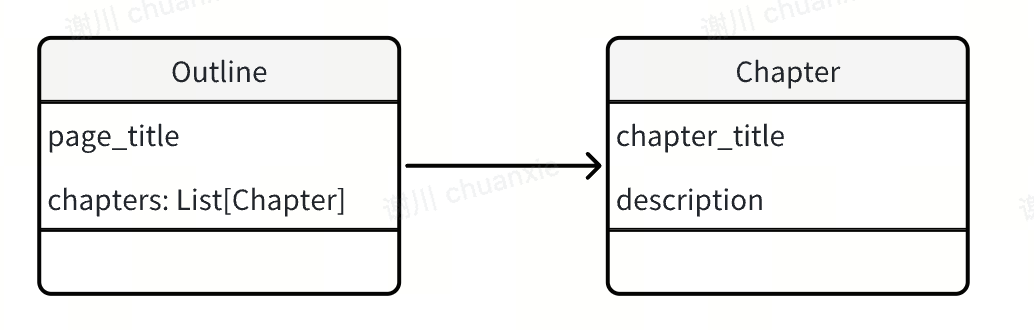

In [69]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional,Any
class Chapter(BaseModel):
    chapter_title: str = Field(..., description="Title of the chapter")
    description: str = Field(..., description="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    """
        Outline class to format the LLM output
    """
    page_title: str = Field(..., description="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="Titles and descriptions for each chapter of the comics book.",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()

### 4.2 Define prompt template and LLM chain

In [70]:
from story_agents.prompts import fc_desc
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

In [71]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config["cartoonist"]+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [72]:
# define a chain
generate_outline_direct = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)

- test for generation
- If you encounter JSONDecodeError, please rerun again
-  Give a story topic, you can replace "Place your own idea here" of below topic variable with your own idea

In [ ]:
topic = "Place your own idea here"
#example idea
#topic = "A little boy who lived in a mountain village obtained a magic book in the wild. He became self-taught and became the most powerful magician in the world, helping the world resist alien invasions. "

In [74]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}")],"schema":Outline.schema_json() })
print(outline.as_str)

Okay, here is an outline for a comics book on the topic you provided:
<answer>
{
  "page_title": "The Boy Magician",
  "chapters": [
    {
      "chapter_title": "The Magic Book",
      "description": "A young boy named Kai lives in a remote mountain village. While exploring the woods one day, he stumbles upon an ancient, dusty book filled with arcane symbols and magical incantations. Intrigued, Kai takes the book home and begins studying it in secret."
    },
    {
      "chapter_title": "Mastering the Mystic Arts",
      "description": "Through years of dedicated study and practice, Kai unlocks the secrets of the magic book. He learns to harness mystical energies and cast powerful spells. His abilities grow rapidly, far surpassing those of any other magician in the world."
    },
    {
      "chapter_title": "The Alien Invasion",
      "description": "One day, a massive alien armada arrives on Earth, intent on conquering the planet. Their advanced technology proves too much for Earth

### 4.3 Create characters

- Create a Character class to format the LLM output
- Characters consist of a main character and serveral supporting characters
- each character has own persona

In [75]:
class Persona(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the character.",
    )
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story, such as personality, hobbies, etc..",
    )
    figure: str = Field(
        description="figure representing such as a boy,a girl,a man, a women, a young woman,an old man or etc",
    )
    appearance: str = Field(
        description="appearance, attire of the character in the story.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nBackground: {self.background}\nFigure:{self.figure}\nAppearance: {self.appearance}\n"
    
class Character(BaseModel):
    main_character: Persona = Field(
        description="the main character in the story.",
    )
    
    supporting_character: List[Persona] = Field(
        description="Comprehensive list of supporting characters in the story.",
        min_items=1,
        max_items=3,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.supporting_character])+'\n'+self.main_character.persona

- prompt template 

In [76]:
gen_character_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
           role_config["screenwriter"]+ fc_desc,
        ),
         MessagesPlaceholder(variable_name="messages")
    ]
)
gen_characters_chain = gen_character_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)

- test for generation

In [77]:
request = HumanMessage(content=f"Here is the outline:{outline.json()}")
characters = gen_characters_chain.invoke({"messages": [request],"schema":Character.schema_json()})

<answer>
{
  "main_character": {
    "affiliation": "Mountain Village",
    "name": "Kai",
    "role": "Protagonist",
    "background": "A curious and determined young boy from a remote mountain village who discovers an ancient magic book and dedicates himself to mastering its mystic arts.",
    "figure": "a boy",
    "appearance": "Kai has a lean, athletic build from years of running and playing in the mountains. His dark hair is often tousled, and his eyes shine with intelligence and wonder."
  },
  "supporting_character": [
    {
      "affiliation": "Alien Armada",
      "name": "Zyrax",
      "role": "Antagonist",
      "background": "The merciless supreme commander of the alien invasion force, driven by an insatiable lust for conquest and domination.",
      "figure": "an alien",
      "appearance": "Zyrax is a towering, imposing figure with metallic grey skin and glowing red eyes. His body is augmented with advanced cybernetic implants, and he wears ornate battle armor."
    },


In [78]:
print(characters.as_str)

Name: Zyrax
Role: Antagonist
Affiliation: Alien Armada
Background: The merciless supreme commander of the alien invasion force, driven by an insatiable lust for conquest and domination.
Figure:an alien
Appearance: Zyrax is a towering, imposing figure with metallic grey skin and glowing red eyes. His body is augmented with advanced cybernetic implants, and he wears ornate battle armor.

Name: General_Katrina
Role: Ally
Affiliation: Earth's Military
Background: A brilliant military strategist who initially leads Earth's defenses against the alien invasion before recognizing Kai's superior magical abilities.
Figure:a woman
Appearance: General Katrina is a striking woman in her early 40s with piercing green eyes and chestnut hair pulled back in a tight bun. She carries herself with an air of authority and wears a crisp military uniform.

Name: Archmage_Aldrin
Role: Mentor
Affiliation: Magical Order
Background: An ancient and incredibly powerful wizard who serves as Kai's teacher and guide,

### 4.4 Refine outline by adding characters

- test for refine generation

In [79]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}"),
                                                               AIMessage(content=f"Here is the outline draft:{outline.json()}, "),
                                                               HumanMessage(content=f"Here is the characters description:{characters.json()}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific ")],
                                          "schema":Outline.schema_json() })

Here is the revised outline with the characters incorporated:

<answer>
{
  "page_title": "The Boy Magician",
  "chapters": [
    {
      "chapter_title": "The Magic Book",
      "description": "A young boy named Kai from a remote mountain village stumbles upon an ancient, dusty book filled with arcane symbols and magical incantations while exploring the woods. Intrigued, he takes the book home and begins studying it in secret under the guidance of the wise Archmage Aldrin."
    },
    {
      "chapter_title": "Mastering the Mystic Arts",
      "description": "Over many years, Kai dedicates himself to unlocking the secrets of the magic book. With Aldrin's mentorship, he learns to harness mystical energies and cast increasingly powerful spells, his abilities rapidly surpassing those of any other magician."
    },
    {
      "chapter_title": "The Alien Invasion",
      "description": "One day, a massive alien armada led by the merciless Zyrax arrives, intent on conquering Earth. Their a

In [80]:
print(outline.as_str)

# The Boy Magician

## The Magic Book

A young boy named Kai from a remote mountain village stumbles upon an ancient, dusty book filled with arcane symbols and magical incantations while exploring the woods. Intrigued, he takes the book home and begins studying it in secret under the guidance of the wise Archmage Aldrin.

## Mastering the Mystic Arts

Over many years, Kai dedicates himself to unlocking the secrets of the magic book. With Aldrin's mentorship, he learns to harness mystical energies and cast increasingly powerful spells, his abilities rapidly surpassing those of any other magician.

## The Alien Invasion

One day, a massive alien armada led by the merciless Zyrax arrives, intent on conquering Earth. Their advanced technology overwhelms the military forces led by General Katrina. When all seems lost, Kai steps forward, ready to unleash his incredible magical powers against the alien threat.

## The Battle for Earth

In an epic clash, Kai's magic goes head-to-head against Z

## 5 build outline workflow graph
- 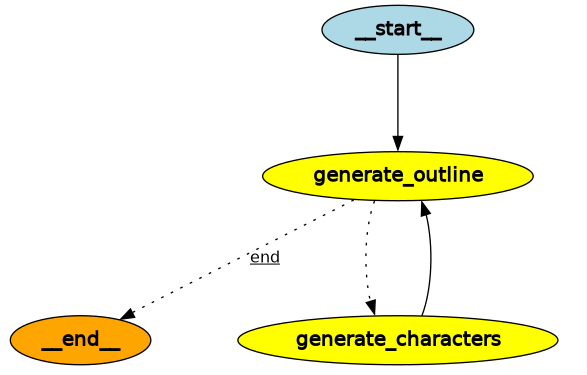

### 5.1 Define node functions

In [81]:
from story_agents.graph_utils import AgentState, retry_call
from langgraph.graph import StateGraph, END
async def generate_outline(state:AgentState):
    """
    Generate outline

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_outline---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    generate_outline_chain = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=False) | RunnableLambda(dict_to_obj).bind(target=Outline)
    name = "cartoonist"
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(messages)
    outline = await retry_call(generate_outline_chain,{"messages": messages,"schema":Outline.schema_json() })
    response = AIMessage(content=f"Here is the outline: \n{outline.json()}",name=name)
    return {"messages":[response],"env_var":{**env_var,"outline":outline}}

async def generate_characters(state:AgentState):
    """
    Generate characters

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_characters---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    name = 'screenwriter'
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(state['messages'])
    gen_characters_chain = gen_character_prompt | llm_sonnet | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=Character)
    characters = await retry_call(gen_characters_chain,{"messages": messages,"schema":Character.schema_json() })
    print("characters",characters)
    response = AIMessage(content=f"Here is the characters description:\n{characters.json()}.\n Your task is to rewrite the outline draft for a story based on the outline draft. Please incorporate all the characters in the story, and keep the outline be comprehensive and specific ",name=name)

    return {"messages":[response],"env_var":{**env_var,"characters":characters}}

### 5.2 Add conditional edge, it repeat the flow untill reaches the max turns

In [82]:
MAX_TURNS = 3
def should_repeat_outline(state: AgentState):
    messages = state['messages']
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print('messages:',num_responses)
    if num_responses > MAX_TURNS:
        return 'end'
    else:
        return 'generate_characters'

### 5.3 build workflow

In [83]:
outline_graph = StateGraph(AgentState)
outline_graph.add_node("generate_outline",generate_outline)
outline_graph.add_node("generate_characters",generate_characters)
outline_graph.set_entry_point("generate_outline")
outline_graph.add_edge("generate_characters", "generate_outline")
outline_graph.add_conditional_edges("generate_outline",
                                   should_repeat_outline,
                                   {
                                       'end':END,
                                       'generate_characters':'generate_characters'
                                   }
                                   )
outline_workflow = outline_graph.compile()

- print out the graph

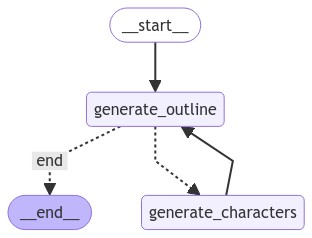

In [99]:
from IPython.display import Image
Image(outline_workflow.get_graph().draw_mermaid_png())

- test generation

In [84]:
steps = []
init_state = {
    "env_var":{"topic":topic},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}
async for event in outline_workflow.astream(init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---generate_outline---
messages: 1
Output from node 'generate_outline':
---
{'messages': [AIMessage(content='Here is the outline: \n{"page_title": "The Boy Magician\'s Adventures", "chapters": [{"chapter_title": "The Discovery", "description": "A young boy named Liam, living in a remote mountain village, stumbles upon a mysterious book hidden deep in the forest. As he opens it, he realizes it\'s a tome of ancient magic spells and rituals."}, {"chapter_title": "The Self-Study", "description": "Fascinated by the book\'s contents, Liam begins studying it in secret, teaching himself the ways of magic. His natural talent and dedication allow him to quickly master spells beyond his years."}, {"chapter_title": "The Alien Invasion", "description": "As Liam\'s powers grow, a terrifying alien force arrives on Earth, intent on conquering the planet. The world\'s military is no match for their advanced technology."}, {"chapter_title": "The Boy Magician", "description": "With his newfound abilities

NameError: name 'JSONDecodeError' is not defined

#### retrieve outline and characters objects from the final step

In [85]:
outline = steps[-1]['generate_outline']['env_var']['outline']

In [86]:
characters = steps[-1]['generate_outline']['env_var']['characters']

In [87]:
print(outline.as_str)

# The Last Magician

## The Ancient Tome

In a remote mountain village, a young boy named Liam stumbles upon an ancient tome of magic hidden deep in the forest. His curiosity piqued, he begins studying its arcane contents in secret, honing his natural talent for the mystic arts.

## Zarina's Guidance

Zarina, a centuries-old sorceress and the last surviving member of the Ancient Order of Mages, senses Liam's potential. She seeks him out and becomes his mentor, guiding him in mastering the tome's powerful spells and rituals.

## The Alien Invasion

As Liam's powers grow, a terrifying alien force led by the merciless overlord Zythor arrives, intent on conquering Earth. The world's military proves no match for their advanced technology, and all hope seems lost.

## The Boy Magician Rises

With Zarina's guidance and the support of his childhood friend Mira, Liam steps forward as Earth's last defense. He uses his newfound magical abilities to turn the tide against the alien invaders, outsma

In [88]:
print(characters.as_str)

Name: Zarina
Role: Mentor
Affiliation: The Ancient Order of Mages
Background: Zarina is a centuries-old sorceress and the last surviving member of the Ancient Order of Mages. She senses Liam's potential and guides him in mastering his powers.
Figure:an old woman
Appearance: Zarina has long, silver hair, piercing blue eyes, and wears flowing robes adorned with mystical symbols.

Name: Zythor
Role: Nemesis
Affiliation: The Alien Invaders
Background: Zythor is the merciless overlord of the alien invasion force. He seeks to conquer Earth and harness its resources for his empire's gain.
Figure:an alien
Appearance: Zythor has a towering, muscular physique, reptilian features, and wears advanced alien armor and weaponry.

Name: Mira
Role: Childhood Friend
Affiliation: The Mountain Village
Background: Mira is Liam's best friend from the village. She stands by his side, providing unwavering support and loyalty as he embarks on his magical journey.
Figure:a young girl
Appearance: Mira has long, 

In [91]:
print(outline.as_str)

# The Last Magician

## The Ancient Tome

In a remote mountain village, a young boy named Liam stumbles upon an ancient tome of magic hidden deep in the forest. His curiosity piqued, he begins studying its arcane contents in secret, honing his natural talent for the mystic arts.

## Zarina's Guidance

Zarina, a centuries-old sorceress and the last surviving member of the Ancient Order of Mages, senses Liam's potential. She seeks him out and becomes his mentor, guiding him in mastering the tome's powerful spells and rituals.

## The Alien Invasion

As Liam's powers grow, a terrifying alien force led by the merciless overlord Zythor arrives, intent on conquering Earth. The world's military proves no match for their advanced technology, and all hope seems lost.

## The Boy Magician Rises

With Zarina's guidance and the support of his childhood friend Mira, Liam steps forward as Earth's last defense. He uses his newfound magical abilities to turn the tide against the alien invaders, outsma

#### Save to local files

In [92]:
with open('characters.json','w') as f:
    f.write(characters.json())

In [93]:
with open('outline.json','w') as f:
    f.write(outline.json())